<a href="https://colab.research.google.com/github/SergeyShchus/OSM/blob/main/Notebook/OSMX_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install osmnx

In [2]:
import networkx as nx
import osmnx as ox

%matplotlib inline
ox.__version__

'1.1.2'

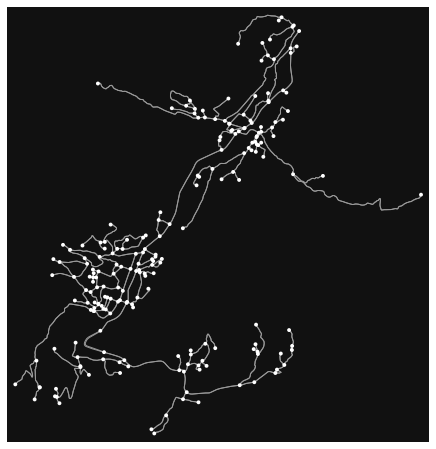

In [31]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place("Yaremche, Ukraine", network_type="drive")
fig, ax = ox.plot_graph(G)

In [32]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.utils_graph.get_digraph(G)

In [33]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
284609964,48.481230,24.592281,3,NaN,POINT (24.59228 48.48123)
284625788,48.431214,24.581159,3,NaN,POINT (24.58116 48.43121)
393960623,48.456255,24.556445,3,NaN,POINT (24.55644 48.45626)
393960641,48.445643,24.550532,3,NaN,POINT (24.55053 48.44564)
393960648,48.443389,24.548046,3,NaN,POINT (24.54805 48.44339)


In [34]:
gdf_edges.head()

osmid  ... bridge
u         v          key                                                     ...       
284609964 394579370  0                                             34375152  ...    NaN
          394579323  0                                            138395030  ...    NaN
          394579332  0                                            138395030  ...    NaN
284625788 3217122085 0    [315585027, 646402020, 646402021, 646402019, 3...  ...    NaN
          2082968945 0                                            367960519  ...    NaN

[5 rows x 10 columns]

In [35]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

In [36]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

37491300.16350259

In [37]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'circuity_avg': 1.1422840013631896,
 'clean_intersection_count': 122,
 'clean_intersection_density_km': 3.2540882676233727,
 'edge_density_km': 3963.5987909712726,
 'edge_length_avg': 310.23063048016684,
 'edge_length_total': 148600.47199999992,
 'intersection_count': 132,
 'intersection_density_km': 3.5208168141498786,
 'k_avg': 4.4766355140186915,
 'm': 479,
 'n': 214,
 'node_density_km': 5.707990895667227,
 'self_loop_proportion': 0.0,
 'street_density_km': 2004.112038588219,
 'street_length_avg': 311.7708132780083,
 'street_length_total': 75136.766,
 'street_segment_count': 241,
 'streets_per_node_avg': 2.2663551401869158,
 'streets_per_node_counts': {0: 0, 1: 82, 2: 2, 3: 121, 4: 9},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.38317757009345793,
  2: 0.009345794392523364,
  3: 0.5654205607476636,
  4: 0.04205607476635514}}

In [38]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath="./data/mynetwork.gpkg")
ox.save_graphml(G, filepath="./data/mynetwork.graphml")

In [39]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

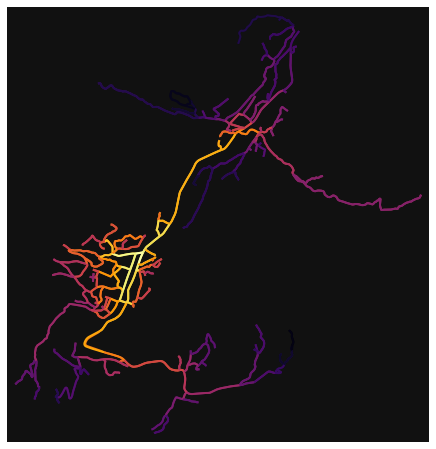

In [40]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

In [41]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [53]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, Y=48.482272, X=24.543283)
dest = ox.distance.nearest_nodes(G, Y=48.430131, X=24.589288)

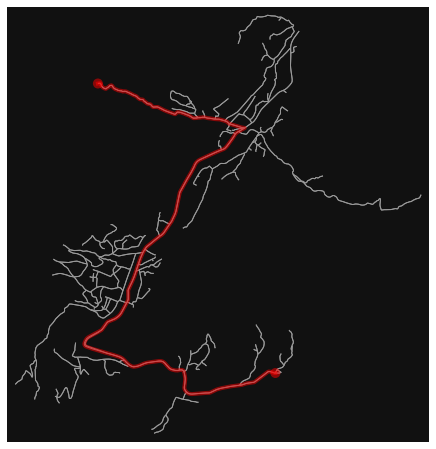

In [54]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [55]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
round(sum(edge_lengths))

12711

In [56]:
# how far is it between these two nodes as the crow flies?
# use OSMnx's vectorized great-circle distance (haversine) function
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle_vec(orig_y, orig_x, dest_y, dest_x))

6406

In [57]:
# add elevation to nodes automatically, calculate edge grades, plot network
# you need a google elevation api key to run this cell!
try:
    from keys import google_elevation_api_key

    G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
    G = ox.elevation.add_edge_grades(G)
    nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
    fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")
except ImportError:
    print("You need a google_elevation_api_key to run this cell.")

You need a google_elevation_api_key to run this cell.


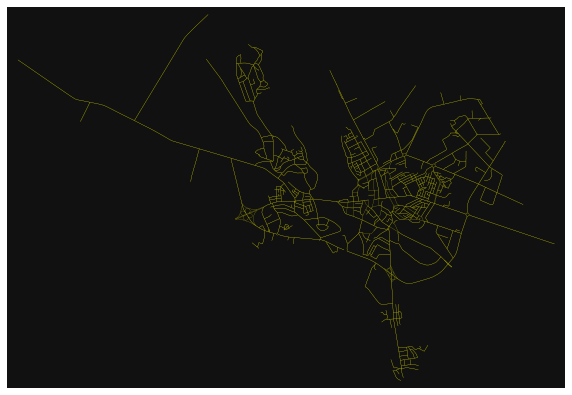

In [78]:
# you can make query an unambiguous dict to help the geocoder find it
place = {"city": "Ternopol",  "country": "Ukraine"}
G = ox.graph_from_place(place, network_type="drive", truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color="y", edge_linewidth=0.2)

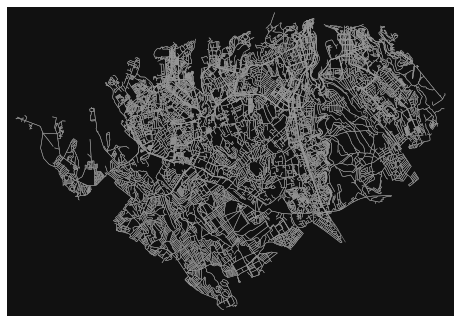

In [61]:
# you can get networks anywhere in the world
G = ox.graph_from_place("Sevastopol, Ukraine", network_type="all")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

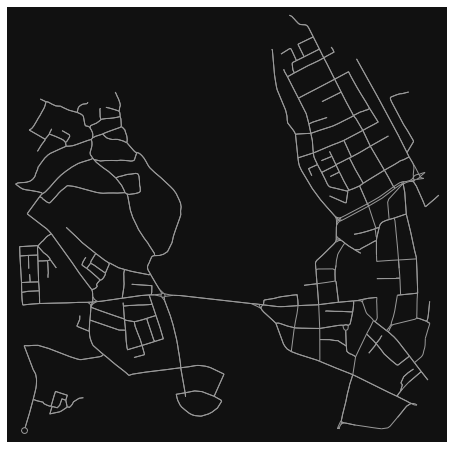

In [64]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (49.556140, 25.579535)
one_mile = 1609  # meters
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0)

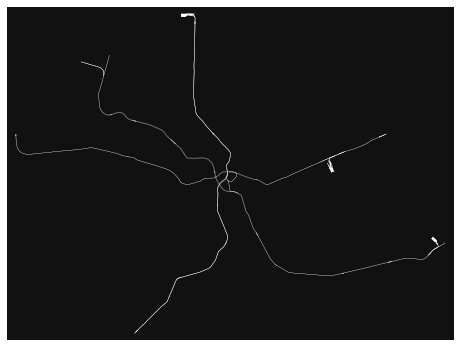

In [66]:
# get NY subway rail network
G = ox.graph_from_place(
    "Kyiv, Ukraine",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

In [67]:
# get all building footprints in some neighborhood
place = "VDNG, Kyiv, Ukraine"
tags = {"building": True}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

(120, 37)

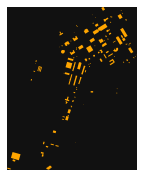

In [68]:
fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

In [69]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park", "highway": "bus_stop"}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

(2, 14)

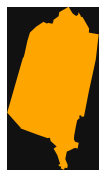

In [70]:
fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))